# open-closed eye detection

In [3]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
from tensorflow  import keras
from keras import layers, models
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.models import load_model



example

In [4]:
pic=plt.imread("/kaggle/input/mrl-dataset/train/Open_Eyes/s0001_02334_0_0_1_0_0_01.png")


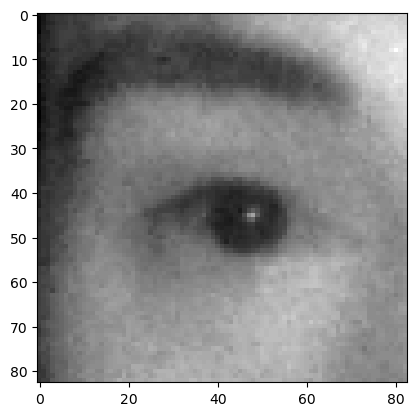

In [5]:
plt.imshow(pic, cmap="gray")

In [6]:
pic.shape

(83, 83)

# Preprocessing and preparation of the data


In [7]:
def apply_data_augmentation(img):
    # Randomly flip the image horizontally
    if random.random() > 0.5:
        img = cv2.flip(img, 1)

    # Randomly flip the image vertically
    if random.random() > 0.5:
        img = cv2.flip(img, 0)

    # Randomly rotate the image by an angle between -15 and 15 degrees
    angle = random.uniform(-15, 15)
    rows, cols, _ = img.shape
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    img = cv2.warpAffine(img, M, (cols, rows))

    # Randomly shift the image horizontally and vertically by up to 10% of the image size
    shift_x = random.randint(-int(0.1 * cols), int(0.1 * cols))
    shift_y = random.randint(-int(0.1 * rows), int(0.1 * rows))
    M = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
    img = cv2.warpAffine(img, M, (cols, rows))

    return img

In [8]:

def create_training_data(Classes, Datadirectory, img_size):
    training_data = []
    for category in Classes:
        path = os.path.join(Datadirectory, category)
        class_num = Classes.index(category)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)

            # Resize the image while maintaining the aspect ratio
            desired_size = (img_size, img_size)
            height, width = img_array.shape
            aspect_ratio = width / height

            if aspect_ratio >= 1:
                new_width = desired_size[0]
                new_height = int(new_width / aspect_ratio)
            else:
                new_height = desired_size[1]
                new_width = int(new_height * aspect_ratio)

            resized_image = cv2.resize(img_array, (new_width, new_height))

            # Pad the resized image to make it square (img_size x img_size)
            pad_width = (desired_size[1] - new_height) // 2
            pad_height = (desired_size[0] - new_width) // 2
            padded_image = np.pad(resized_image, ((pad_width, pad_width), (pad_height, pad_height)), mode='constant', constant_values=0)

            # Normalize the pixel values to [0, 1] using Minmax normalization
            normalized_image = padded_image / 255.0

            # Convert the grayscale image to RGB
            rgb_image = cv2.cvtColor(padded_image, cv2.COLOR_GRAY2RGB)
            
            #perform data_augmentation
            #rgb_image = apply_data_augmentation(rgb_image)
            training_data.append([rgb_image, class_num])

    print("Data processing completed.")
    return training_data

In [9]:
Datadirectory = '/kaggle/input/mrl-dataset/train'
Classes = ['Closed_Eyes', 'Open_Eyes']
img_size = 100
training_data = create_training_data(Classes, Datadirectory, img_size)

Data processing completed.


# Shuffle and reshape the data

In [11]:
random.shuffle(training_data)


In [12]:
X = []
y = []
for features, label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, img_size, img_size, 3)
Y=np.array(y)

# Building the model

In [23]:
from keras.applications import MobileNetV2
from keras import models, layers
from keras.applications.mobilenet_v2 import preprocess_input
from keras.regularizers import l2
import numpy as np

# Define the input shape for the models
input_shape = (100, 100, 3)

# Load MobileNetV2 model with default input shape (224, 224, 3)
mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Resize input images to (224, 224) and preprocess them
def resize_input(x):
    return tf.image.resize(x, (224, 224))

# Create your custom model
custom_model = models.Sequential()
custom_model.add(layers.Lambda(resize_input, input_shape=input_shape))  # Resize input images
custom_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
custom_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
custom_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
custom_model.add(layers.MaxPooling2D((2, 2)))
custom_model.add(layers.Conv2D(256, (3, 3), activation='relu'))
custom_model.add(layers.MaxPooling2D((2, 2)))
custom_model.add(layers.Conv2D(384, (3, 3), activation='relu'))
custom_model.add(layers.MaxPooling2D((2, 2)))
custom_model.add(layers.Conv2D(512, (3, 3), activation='relu'))
custom_model.add(layers.MaxPooling2D((2, 2)))
custom_model.add(layers.Conv2D(1024, (3, 3), activation='relu'))
custom_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output from Conv2D layers
custom_model.add(layers.Flatten())

# Add fully connected layers with specified parameters and L2 regularization
custom_model.add(layers.Dense(16384, activation='relu', kernel_regularizer=l2(0.01)))
custom_model.add(layers.Dense(180, activation='relu', kernel_regularizer=l2(0.01)))
custom_model.add(layers.Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
custom_model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))

# Combine both models into an ensemble model
# Get the output from the MobileNetV2 model
mobilenet_output = mobilenet_model(custom_model.layers[0].output)

# Flatten the output from the MobileNetV2 model
mobilenet_output_flatten = layers.GlobalAveragePooling2D()(mobilenet_output)

# Get the output from the custom model
custom_output = custom_model.layers[-1].output

# Create the ensemble model by concatenating the outputs from MobileNetV2 and the custom model
ensemble_output = layers.concatenate([mobilenet_output_flatten, custom_output])

# Add fully connected layers with specified parameters
ensemble_output = layers.Dense(256, activation='relu')(ensemble_output)
ensemble_output = layers.Dropout(0.5)(ensemble_output)
ensemble_output = layers.Dense(1, activation='sigmoid')(ensemble_output)

# Create the ensemble model
ensemble_model = models.Model(inputs=custom_model.input, outputs=ensemble_output)

# Compile the ensemble model with an appropriate optimizer, loss, and metrics
ensemble_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the summary of the ensemble model
ensemble_model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 lambda_4_input (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_4 (Lambda)              (None, 224, 224, 3)  0           ['lambda_4_input[0][0]']         
                                                                                                  
 conv2d_36 (Conv2D)             (None, 222, 222, 32  896         ['lambda_4[0][0]']               
                                )                                                                 
                                                                                            

In [24]:

ensemble_model.compile(loss="binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=3, mode='max', verbose=1)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)

# Assuming you have your data in X_train and y_train arrays, perform K-Fold cross-validation
k = 5
fold_size = len(X_train) // k
for i in range(k):
    start = i * fold_size
    end = (i + 1) * fold_size

    x_val = X_train[start:end]
    y_val = Y_train[start:end]

    x_train = np.concatenate([X_train[:start], X_train[end:]])
    y_train = np.concatenate([Y_train[:start], Y_train[end:]])

    # Train the model
    ensemble_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=32, verbose=1, callbacks=[early_stopping_callback])


Epoch 1/20
80/80 [==============================] - 85s 669ms/step - loss: 10.9755 - accuracy: 0.9836 - val_loss: 8.9733 - val_accuracy: 0.5047
Epoch 2/20
80/80 [==============================] - 52s 651ms/step - loss: 0.1117 - accuracy: 0.9973 - val_loss: 6.7103 - val_accuracy: 0.5266
Epoch 3/20
80/80 [==============================] - 55s 692ms/step - loss: 0.0148 - accuracy: 0.9988 - val_loss: 0.2712 - val_accuracy: 0.9781
Epoch 4/20
80/80 [==============================] - 55s 694ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.0473 - val_accuracy: 0.9937
Epoch 5/20
80/80 [==============================] - 54s 670ms/step - loss: 0.0152 - accuracy: 0.9961 - val_loss: 0.9065 - val_accuracy: 0.9859
Epoch 6/20
80/80 [==============================] - 55s 694ms/step - loss: 0.0246 - accuracy: 0.9934 - val_loss: 36.5875 - val_accuracy: 0.5047
Epoch 7/20
80/80 [==============================] - 55s 694ms/step - loss: 0.0073 - accuracy: 0.9980 - val_loss: 29.0097 - val_accuracy: 0.5

In [16]:
# Train the model with EarlyStopping callback
#history = ensemble_model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_val, Y_val), callbacks=[early_stopping_callback])

#model.save('my_model.h5')


Epoch 1/20
100/100 [==============================] - 119s 620ms/step - loss: 0.0328 - accuracy: 0.9853 - val_loss: 11.5668 - val_accuracy: 0.5013
Epoch 2/20
100/100 [==============================] - 62s 621ms/step - loss: 1.9150e-04 - accuracy: 1.0000 - val_loss: 5.2033 - val_accuracy: 0.5013
Epoch 3/20
100/100 [==============================] - 62s 622ms/step - loss: 2.2389e-05 - accuracy: 1.0000 - val_loss: 3.5972 - val_accuracy: 0.5013
Epoch 4/20
100/100 [==============================] - 62s 619ms/step - loss: 5.0922e-06 - accuracy: 1.0000 - val_loss: 2.1449 - val_accuracy: 0.5088
Epoch 5/20
100/100 [==============================] - 62s 621ms/step - loss: 0.0206 - accuracy: 0.9934 - val_loss: 41.3572 - val_accuracy: 0.5013
Epoch 6/20
100/100 [==============================] - 62s 623ms/step - loss: 0.0335 - accuracy: 0.9934 - val_loss: 47.5529 - val_accuracy: 0.5013
Epoch 7/20
100/100 [==============================] - 62s 622ms/step - loss: 0.0013 - accuracy: 0.9994 - val_loss:

NameError: name 'model' is not defined

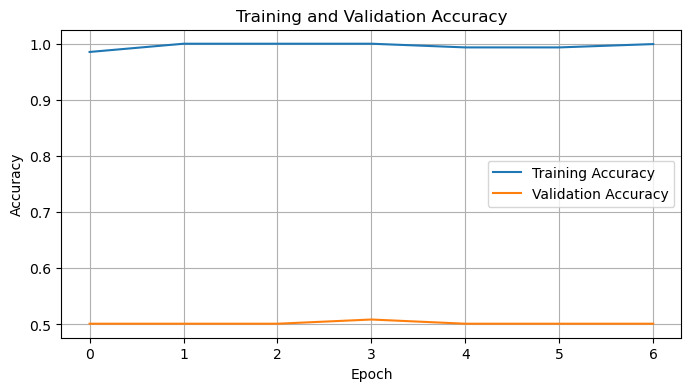

In [25]:
# Plot training and validation accuracy
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Make predicitons

In [26]:
import cv2
import numpy as np

def preprocess_single_image(image_path, img_size):
    # Read the image in grayscale
    img_array = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Resize the image while maintaining the aspect ratio
    desired_size = (img_size, img_size)
    height, width = img_array.shape
    aspect_ratio = width / height

    if aspect_ratio >= 1:
        new_width = desired_size[0]
        new_height = int(new_width / aspect_ratio)
    else:
        new_height = desired_size[1]
        new_width = int(new_height * aspect_ratio)

    resized_image = cv2.resize(img_array, (new_width, new_height))

    # Pad the resized image to make it square (img_size x img_size)
    pad_width = (desired_size[1] - new_height) // 2
    pad_height = (desired_size[0] - new_width) // 2
    padded_image = np.pad(resized_image, ((pad_width, pad_width), (pad_height, pad_height)), mode='constant', constant_values=0)

    # Normalize the pixel values to [0, 1] using Minmax normalization
    normalized_image = padded_image / 255.0

    # Convert the grayscale image to RGB
    rgb_image = cv2.cvtColor(padded_image, cv2.COLOR_GRAY2RGB)
    #rgb_image = apply_data_augmentation(rgb_image)
    return rgb_image


In [34]:
image_path = "/kaggle/input/mrl-dataset/train/Closed_Eyes/s0001_00024_0_0_0_0_0_01.png"
tttt=plt.imread(image_path)
print(tttt.shape)
preprocessed_image = preprocess_single_image(image_path, img_size)

# Reshape the preprocessed image to match the input shape of the model
preprocessed_image = resized_image.reshape(-1, img_size, img_size, 3)

# Make predictions using the model
predictions = ensemble_model.predict(preprocessed_image)
print(predictions)
# The 'predictions' variable will contain the probability of the image belonging to each class.
# You can use 'np.argmax(predictions)' to get the predicted class index with the highest probability.


(80, 80)
1/1 [==============================] - 0s 25ms/step
[[1.]]


# TESTING

In [38]:
TESTdirectory = '/kaggle/input/yawn-eye-dataset-new/dataset_new/test'
Classes_test = ['Closed', 'Open']
img_size = 100
testing_data = create_training_data(Classes_test, TESTdirectory, img_size)
random.shuffle(testing_data)

X_test = []
y_test = []

for features, label in training_data:
    X_test.append(features)
    y_test.append(label)

X_test = np.array(X_test).reshape(-1, img_size, img_size, 3)
Y_test=np.array(y_test)

Data processing completed.


125/125 [==============================] - 21s 171ms/step
Test Loss: 54.486717224121094
Test Accuracy: 0.5
Accuracy: 0.5
Precision: 0.5
Recall: 1.0
F1 Score: 0.6666666666666666
Confusion Matrix:
[[   0 2000]
 [   0 2000]]
AUC-ROC: 0.5


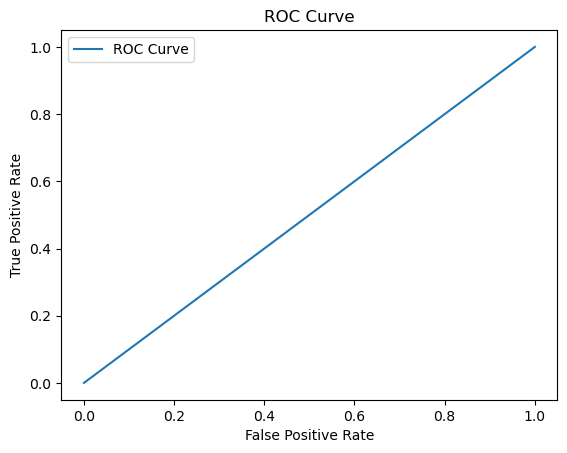

In [45]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score

# Evaluate the model on the test dataset (X_test and y_train)
test_loss, test_accuracy = ensemble_model.evaluate(X_test, Y_test)

# Make predictions on the test dataset (X_test)
predictions = ensemble_model.predict(X_test)

# Convert probabilities to binary predictions using a threshold of 0.5
binary_predictions = (predictions > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(Y_test, binary_predictions)

# Calculate precision, recall, and F1 score
precision = precision_score(Y_test, binary_predictions)
recall = recall_score(Y_test, binary_predictions)
f1 = f1_score(Y_test, binary_predictions)

# Calculate confusion matrix
conf_matrix = confusion_matrix(Y_test, binary_predictions)

# Calculate ROC curve and AUC-ROC
fpr, tpr, thresholds = roc_curve(Y_test, predictions)
auc_roc = roc_auc_score(Y_test, predictions)

# Print the evaluation metrics
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)
print(f"AUC-ROC: {auc_roc}")

# Plot ROC curve
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
